# Exercise 3

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tensorboard
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import os
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import seaborn as sns
import pandas as pd


# Defining CNN

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size = 5,stride = 1,padding=2)
        self.avgPool = nn.AvgPool2d(kernel_size = 2,stride=2)
        self.conv2 = nn.Conv2d(6,16,kernel_size = 5,stride=1)
        self.conv3 = nn.Conv2d(16,120,kernel_size = 5,stride=1)

        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,10)
        

    def forward(self, x):
        
        x = self.feature_extract(x)
    
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)
    
    def feature_extract(self, x):
        x = F.tanh(self.conv1(x))
        x = self.avgPool(x)
        
        x = F.tanh(self.conv2(x))
        x = self.avgPool(x)
        
        x = F.tanh(self.conv3(x))
        
        x = x.view(-1,120)
        
        return x

cnn_untrained = CNN()
cnn_trained = CNN()

# Setting Hyperparameters

In [4]:
# learning_rate = 1e-6
batch_size_train = 64
batch_size_test = 1000

momentum = 0.5
epochs = 10
log_interval = 100

In [12]:
# optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,
#                       momentum=momentum)

# Downloading MNIST

In [5]:
#MNIST
batch_size_train = 64
batch_size_test = 1000

train_mnist = torchvision.datasets.MNIST('mnist/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))]))


test_mnist = torchvision.datasets.MNIST('mnist/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))]))

train_loader = torch.utils.data.DataLoader(train_mnist,batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist,batch_size=batch_size_test, shuffle=True)


In [6]:
def train(epochs,network,train_loader,optimizer, filename="model.pth"):
    train_losses = []
    train_counter = []
    writer = SummaryWriter()
    
    network.train()
    for epoch in range(epochs):
        
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data)

            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                train_losses.append(loss.item())
                train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    torch.save(network.state_dict(), str('results/'+ filename))
    torch.save(optimizer.state_dict(), str('results/'+ "optimizer_" + filename))


In [7]:
def test(network,test_loader):
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    
    network.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            
    print('\rTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)), end="\r")

# Training CNN (1 epoch and learning rate = 1e-6)

In [8]:
optimizer_untrained = optim.SGD(cnn_untrained.parameters(), lr=1e-6,
                      momentum=momentum)
train(1, cnn_untrained, train_loader, optimizer_untrained)

C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312095
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.314635
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.309683
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.286376
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.305141
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.314110
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.299681
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.303715
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.296737
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.297880


In [9]:
test(cnn_untrained, test_loader)

C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 0.2305, Accuracy: 978/10000 (10%)


# Extracting features from model (virtually not trained)

In [11]:
train_loader_f = torch.utils.data.DataLoader(train_mnist,batch_size=5000, shuffle=True)
images_f, labels_f = next(iter(train_loader_f))
features_f = cnn_untrained.feature_extract(images_f)

In [15]:
def plot(principalDf):
    flatui = ["#9b59b6", "#3498db", "orange"]
    sns.set_palette(flatui)
    sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, fit_reg=False,
               hue='label', legend=False)

    plt.figure(figsize=(13,10))

# Plotting features with PCA

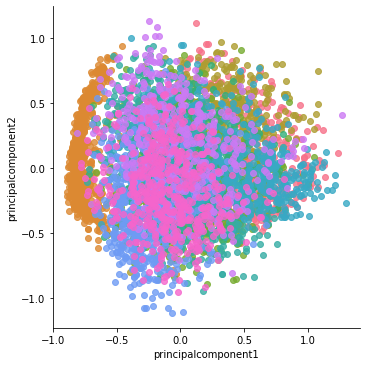

<Figure size 936x720 with 0 Axes>

In [13]:
# features = cnn.feature_extract(torch.Tensor(total_images))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_f.detach().numpy())

principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])

labelPd = pd.DataFrame(labels_f)

principalDf = pd.concat([principalDf, labelPd], axis = 1, join="inner", ignore_index=True)
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]
principalDf.head()

plot(principalDf)



# Plotting features with t-SNE

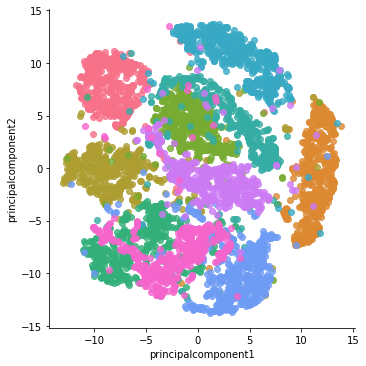

<Figure size 936x720 with 0 Axes>

In [16]:
# features = cnn.feature_extract(torch.Tensor(total_images))
t_sne = TSNE(n_components=2, n_iter=300)
principalComponents = t_sne.fit_transform(features_f.detach().numpy())

principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])

labelPd = pd.DataFrame(labels_f)

principalDf = pd.concat([principalDf, labelPd], axis = 1, join="inner", ignore_index=True)
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]
principalDf.head()

plot(principalDf)



# 1.4 Training CNN on MNIST with learning rate 1e-3 and 20 epochs

In [17]:
learning_rate = 1e-3
optimizer_trained = optim.SGD(cnn_trained.parameters(), lr=learning_rate,
                      momentum=momentum)
train(20, cnn_trained, train_loader, optimizer_trained)

C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303724
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.285663
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.282020
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.265489
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.256151
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.228118
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.218666
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.184214
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.190235
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.121154
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.100273
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.054664
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.025655
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.951013
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.963580
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.766561
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.753974
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.646975
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.599395
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.599040
Train Epoch:

Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.140332
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.214252
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.192235
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.421070
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.216426
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.091567
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.370910
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.539919
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.235237
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.248500
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.354112
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.203487
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.357540
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.280948
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.310678
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.235281
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.241595
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.307783
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.089538
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0

In [18]:
test(cnn_trained, test_loader)

C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 0.0199, Accuracy: 9383/10000 (94%)


# Extracting features from model (trained)

In [19]:
train_loader_f = torch.utils.data.DataLoader(train_mnist,batch_size=5000, shuffle=True)
images_f, labels_f = next(iter(train_loader_f))
features_f = cnn_trained.feature_extract(images_f)

# Plotting features with PCA

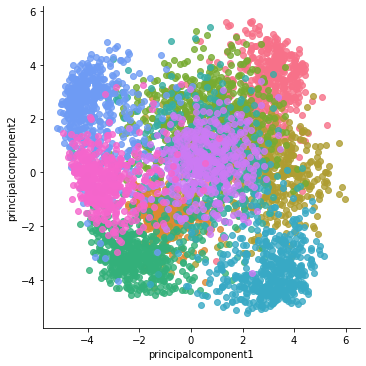

<Figure size 936x720 with 0 Axes>

In [20]:
# features = cnn.feature_extract(torch.Tensor(total_images))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_f.detach().numpy())

principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])

labelPd = pd.DataFrame(labels_f)

principalDf = pd.concat([principalDf, labelPd], axis = 1, join="inner", ignore_index=True)
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]
principalDf.head()

plot(principalDf)


# Plotting features with t_SNE

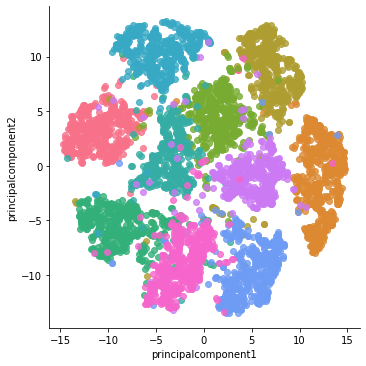

<Figure size 936x720 with 0 Axes>

In [21]:
# features = cnn.feature_extract(torch.Tensor(total_images))
t_sne = TSNE(n_components=2, n_iter=300)
principalComponents = t_sne.fit_transform(features_f.detach().numpy())

principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])

labelPd = pd.DataFrame(labels_f)

principalDf = pd.concat([principalDf, labelPd], axis = 1, join="inner", ignore_index=True)
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]
principalDf.head()

plot(principalDf)


# 1.6 Comments on differences (a) between PCA and t-SNE and (b) the first model (virtually not trained at all) and the second one

## (a) We get a better seperation using t-SNE than with PCA. 

## (b) Comparing the two models we can see that the trained model creates better both PCA and t-SNE